### Meta

In [1]:
# Autoreload modules without having to restart the notebook kernel.
# hi bilbo
%load_ext autoreload
%autoreload 2


# Plotting code stolen from Georg's notebook.
import matplotlib.pyplot as plt

%matplotlib inline
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 32}
plt.rc('font', **font)

### Imports

In [2]:
import sys
sys.path.insert(1, "..\\")

import random

#import markov_clustering as mcl
import networkx as nx

# Personal libraries
import lib.cluster
import lib.graph
import lib.plot
import lib.files

In [3]:
### Constants

In [4]:
ICP55 = '4932.YER078C'
THRESHOLD = 900
MCL_INFLATION = 2  # The parameter controlling Markov Clustering

# ICP55's inviable neighbour.
YHC1 = '4932.YLR298C'

### Data

In [5]:
class Cluster:

    def __init__(self, proteins):
        self.proteins = proteins


class Protein:

    def __init__(self, systemic_name):
        self.systemic_name = systemic_name
        self.clusters = []

        self.neighbourhoods = {}  # Dict indexed by neighbourhood path length.


class NetworkHub:
    """
    The controller passing networks and common data  (e.g. list of inviable proteins)
    """

    def __init__(self, networks, load_inviable_proteins=False):
        self.networks = networks
        self.inviable_proteins = None
        if load_inviable_proteins:
            self.inviable_proteins = lib.graph.read_inviable_proteins()


class NetworkWrapper:
    """
    A wrapper for networks to store additional properties (e.g. clusters)
    """

    def __init__(self, network):
        self.network = network
        self.threshold = THRESHOLD
        self.proteins = [Protein(ICP55)]  # Proteins of interest.
        self.inviable_proteins = lib.graph.read_inviable_proteins()
        self.mcl = None  # MCL

In [6]:
# The first network is the largest connected component containing ICP55 with inviable proteins, has edges above 900 and no degree 0 nodes.
n0 = lib.graph.read_STRING()
n0 = lib.graph.remove_edges_below_threshold(n0, THRESHOLD)
n0 = lib.graph.remove_nodes_with_degree_lte(n0, 0)
n0 = lib.graph.get_largest_cc_with_node(n0, ICP55)
# We only want to look at the largest cc of ICP55.
n0 = NetworkWrapper(n0)

# I want to visualise ICP55 neighbourhoods
n0.neighbourhoods = [
    lib.graph.get_neighbourhood(n0.network, ICP55, path_length=1),
    lib.graph.get_neighbourhood(n0.network, ICP55, path_length=2),
    lib.graph.get_neighbourhood(n0.network, ICP55, path_length=3)
]

# Markov clustering
n0.mcl = lib.cluster.run_mcl(n0.network, inflation=MCL_INFLATION)

# I also want to visualise ICP55 neighbourhoods as clusters
shortest_path_lengths = nx.single_source_shortest_path_length(n0.network, ICP55)
n0.neighbourhood_clusters = [
    lib.cluster.neighbourhood_clusters(n0.mcl.clusters, shortest_path_lengths, path_length=1),
    lib.cluster.neighbourhood_clusters(n0.mcl.clusters, shortest_path_lengths, path_length=2),
    lib.cluster.neighbourhood_clusters(n0.mcl.clusters, shortest_path_lengths, path_length=3)
]
# I use this to overlay ICP55's cluster exclusively on top of graphs.
n0.icp55_cluster = lib.cluster.get_complexes_containing_protein(n0.mcl.clusters, ICP55)[0]

In [7]:
n1 = lib.graph.read_STRING()
n1 = lib.graph.remove_edges_below_threshold(n1, THRESHOLD)
n1 = lib.graph.remove_nodes_with_degree_lte(n1, 0)
n1 = lib.graph.get_largest_cc_with_node(n1, ICP55)
n1 = NetworkWrapper(n1)

n1.neighbourhoods = [
    lib.graph.get_neighbourhood(n1.network, ICP55, path_length=1),
    lib.graph.get_neighbourhood(n1.network, ICP55, path_length=2),
    lib.graph.get_neighbourhood(n1.network, ICP55, path_length=3)
]

n1.mcl = lib.cluster.run_mcl(n1.network, inflation=MCL_INFLATION)

shortest_path_lengths = nx.single_source_shortest_path_length(n1.network, ICP55)
n1.neighbourhood_clusters = [
    lib.cluster.neighbourhood_clusters(n1.mcl.clusters, shortest_path_lengths, path_length=1),
    lib.cluster.neighbourhood_clusters(n1.mcl.clusters, shortest_path_lengths, path_length=2),
    lib.cluster.neighbourhood_clusters(n1.mcl.clusters, shortest_path_lengths, path_length=3)
]
n1.icp55_cluster = lib.cluster.get_complexes_containing_protein(n1.mcl.clusters, ICP55)[
    0]

In [8]:

# Generate a colour for each cluster. They are separated by Hue to make as large a visual diff as possible.
colours = lib.plot.generate_n_colours(len(n0.neighbourhood_clusters[1]))
colours_1 = lib.plot.generate_n_colours(len(n1.neighbourhood_clusters[1]))

# Randomly shuffle colours so large clusters have visibly different colours.
random.shuffle(colours)
random.shuffle(colours_1)

# Zip into tuples of (subgraph, colour)
subgraphs_and_colours = list(zip(map(n0.network.subgraph, n0.neighbourhood_clusters[1]), colours))
subgraphs_and_colours_1 = list(zip(map(n1.network.subgraph, n1.neighbourhood_clusters[1]), colours_1))

# Add in the ICP55 cluster on top with a distinct colour
subgraphs_and_colours += [(n0.network.subgraph(n0.icp55_cluster), 'brown')]
subgraphs_and_colours_1 += [(n1.network.subgraph(n1.icp55_cluster), 'brown')]

In [9]:
print(n0.mcl.modularity)
print(n1.mcl.modularity)

None
None


## ICP55 and inviable proteins
We see ICP55 is not in the list of 'inviable' proteins.

In [10]:
ICP55 in essential_proteins

NameError: name 'essential_proteins' is not defined

However, many exist within 1, 2 and 3 neighbourhoods. Of particular note is YHC1, the inviable neighbour to ICP55 and the cluster of inviable proteins 2 away from ICP55.

Questions for the biology students.
- Is YHC1 known?
- 

NameError: name 'cc' is not defined

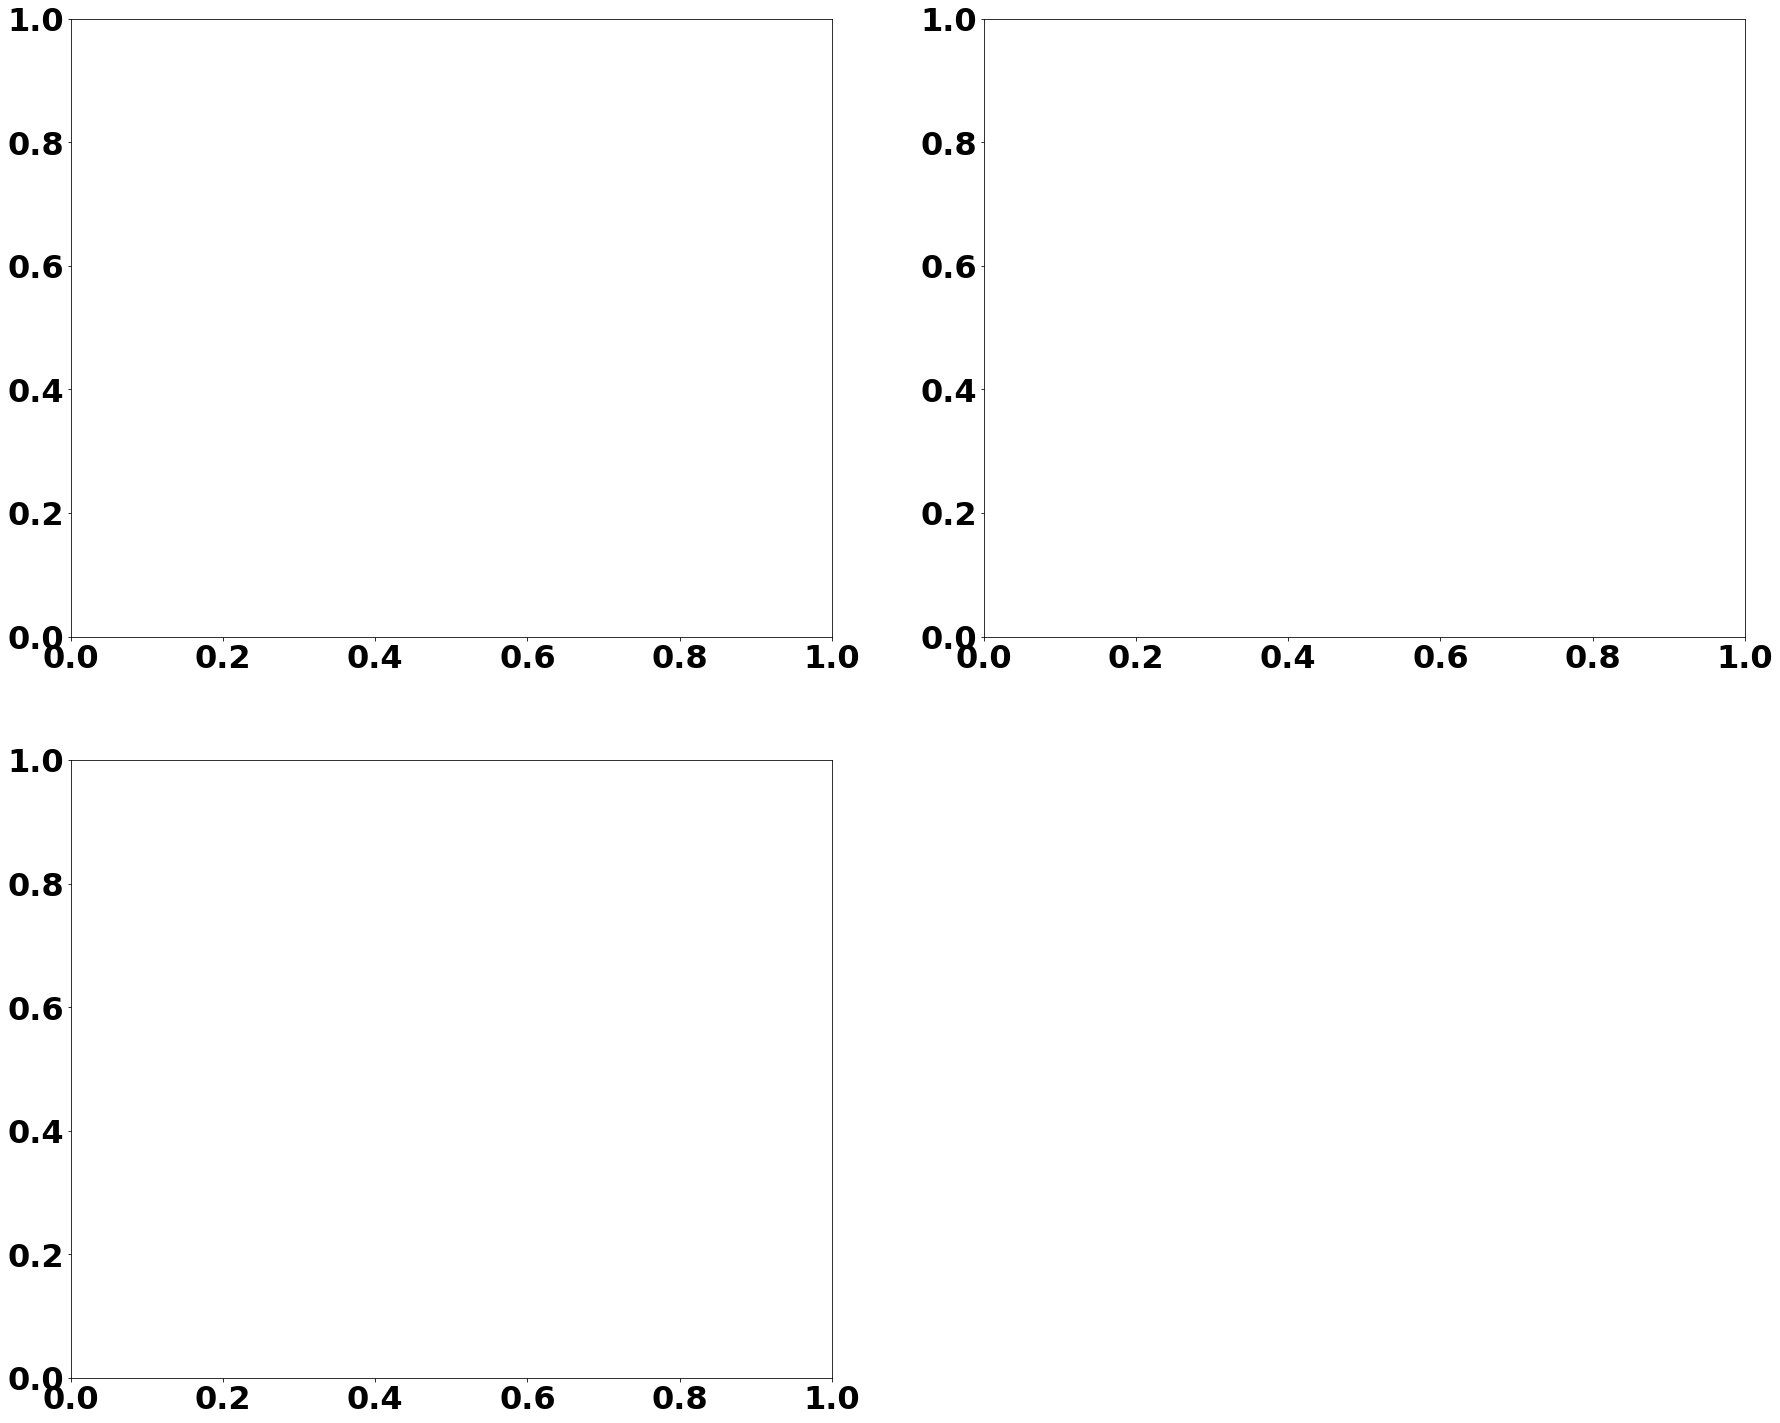

In [11]:
figure = plt.figure(figsize=(30, 25))
ax1 = figure.add_subplot(221)
ax2 = figure.add_subplot(222)
ax3 = figure.add_subplot(223)

lib.plot.network_layers(cc, [
    (neighbourhood_1, 'blue'),
    (essential_proteins, 'red'),
    (graph.subgraph(ICP55), 'yellow')
], base=neighbourhood_1, ax=ax1)
lib.plot.network_layers(cc, [
    (neighbourhood_2, 'blue'),
    (essential_proteins, 'red'),
    (graph.subgraph(ICP55), 'yellow')
], base=neighbourhood_2, ax=ax2)
lib.plot.network_layers(cc, [
    (neighbourhood_3, 'blue'),
    (essential_proteins, 'red'),
    (graph.subgraph(ICP55), 'yellow')
], base=neighbourhood_3, ax=ax3)

figure.show()
# figure.savefig(lib.files.make_filepath_to_graphs('icp55-neighbourhoods-with-inviable-proteins-highlighted.png'))

## Markov Clustering
We can cluster ICP55's largest connected component with ~4500 nodes and ~60000 edges.

In [ ]:
# Convert to sparse matrix to run the algorithm.
matrix = nx.to_scipy_sparse_matrix(cc)
result = mcl.run_mcl(matrix, inflation=2)
clusters = mcl.get_clusters(result)
mcl.draw_graph(matrix, clusters, node_size=50, with_labels=False)

Zooming in on ICP55 we see it does effectively bridge two clusters in the network. It itself exists in a cluster of size 2. However if we remove inviable proteins we lose this interesting bridging feature of ICP55.

In [ ]:
figure = plt.figure(figsize=(30, 50))
ax1 = figure.add_subplot(211)
ax2 = figure.add_subplot(212)

lib.plot.network_layers(cc, subgraphs_and_colours, base=neighbourhood_2, ax=ax1)
lib.plot.network_layers(cc_no_inviable, subgraphs_and_colours_1, base=neighbourhood_2_no_inviable, ax=ax2)

figure.show()